In [34]:
# read in votes as a duckdb and count the number of votes per proposal
import duckdb

db = duckdb.connect(database=':memory:', read_only=False)
# as view
db.execute("CREATE VIEW votes AS SELECT * FROM parquet_scan('{}')".format('../parquets_version3/votes.parquet'))
db.execute("CREATE VIEW proposals AS SELECT * FROM parquet_scan('{}')".format('../parquets_version3/proposals.parquet'))
# same for deployments
db.execute("CREATE VIEW deployments AS SELECT * FROM parquet_scan('{}')".format('../parquets_version3/deployments.parquet'))
# select all
db.execute("SELECT * FROM votes LIMIT 4").fetchdf()

,id,proposal_id,deployment_id,platform_vote_id,voter,date,choice,weight
0,6755eb11-f57b-5841-961b-ededa4411a91,a7f83165-6b46-5aa5-a363-8c803825e9db,f3ef168e-d216-573c-ba95-ff15d29069fe,HFhP5bFDBq6sP54RrkxCir75793686LFCCqbrFRAzgAM,96ZVN79M5QKsJcvXkxuEx9wYWoCYZHtuP1Y8EJhrJyw,NaT,"[{'rank': 0, 'weightPercentage': 100}]",1.0
1,0c79521b-223f-5174-8e00-e7b96bc1b871,a7f83165-6b46-5aa5-a363-8c803825e9db,f3ef168e-d216-573c-ba95-ff15d29069fe,7Cw6ukhy4wuUnFwgqDAA7m7VkVV5QWiGtDRwVmadx5aZ,SQ2t2hU2g5nofFt3D5MhNfaey7QSjEHe5pBEFCPP2F7,NaT,"[{'rank': 0, 'weightPercentage': 100}]",1.0
2,e9895866-0f92-5fd7-945f-3c04dd3692c1,a7f83165-6b46-5aa5-a363-8c803825e9db,f3ef168e-d216-573c-ba95-ff15d29069fe,91z2tkWCnEBo7SyoHogqnnRQURQgi1LEKevwwpa5s3UV,568F8CYYDE9BuKPqw5MzYFqwafDSWagPQMz8XQi19RXq,NaT,"[{'rank': 0, 'weightPercentage': 100}]",1.0
3,e1aada30-aa76-57f1-85d3-9c06da614245,a7f83165-6b46-5aa5-a363-8c803825e9db,f3ef168e-d216-573c-ba95-ff15d29069fe,C2E43Xunhb4xPwcqrb5fvg9MXktJbvUNHGdLiXNKHrci,5qAnY8pqRa4ZyLDmXv8t9eChN52EtZs63SiCPY9KdWJh,NaT,"[{'rank': 0, 'weightPercentage': 100}]",1.0


In [35]:
# select count of proposals per deployment
db.execute("SELECT deployment_id, COUNT(id) FROM proposals GROUP BY deployment_id ORDER BY COUNT(id) DESC").fetchdf()

,deployment_id,count(id)
0,c37abcdd-a36b-51fc-8fa6-2c3ecb780df0,29681
1,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,2744
2,41fd8de5-f8e2-5023-86a3-825c49e9ad7f,1962
3,5deda895-4531-539a-b7dc-88797456ded7,1438
4,d3229595-ac4c-55bf-9808-386fc5603bd1,918
...,...,...
19872,f311cc3b-62e9-543b-a4ec-cfecaeec390b,1
19873,1227c100-5273-51d4-96c1-7520599444ed,1
19874,66bd2f81-1758-58a7-a5a9-ffb1e4fdbedf,1
19875,23448fae-06cf-525e-8ee8-9b0339c1dcb5,1


In [36]:
# get the number of votes per deployment
db.execute("SELECT deployment_id, COUNT(id) FROM votes GROUP BY deployment_id ORDER BY COUNT(id) DESC").fetchdf()

,deployment_id,count(id)
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,5986069
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,3116713
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,2020544
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,1142459
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,899961
...,...,...
16737,df7f5cc5-b7aa-5e9c-997c-bebfb92e1521,1
16738,6a864d09-c971-5018-91a4-25d44d210db6,1
16739,1d675732-6299-5cae-a472-bf98555b83a6,1
16740,3980ce17-277b-571d-80d0-6dc2a23be186,1


In [37]:
# run the same query with the descending ordering but merge with deployments
query = """
SELECT
    d.*,
    p.count as proposals_count_new,
    v.count as votes_count_new
FROM deployments d
LEFT JOIN (
    SELECT deployment_id, COUNT(id) AS count
    FROM proposals
    GROUP BY deployment_id
) p ON d.id = p.deployment_id
LEFT JOIN (
    SELECT deployment_id, COUNT(id) AS count
    FROM votes
    GROUP BY deployment_id
) v ON d.id = v.deployment_id
ORDER BY votes_count_new DESC
"""
deployments_df = db.execute(query).fetchdf()
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count,proposals_count_new,votes_count_new
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",6022932,58,58.0,5986069.0
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",3135558,2,2.0,3116713.0
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2034342,368,367.0,2020544.0
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",1144462,93,93.0,1142459.0
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",1272067,162,122.0,899961.0


votes count

<Axes: xlabel='votes_count', ylabel='votes_count_new'>

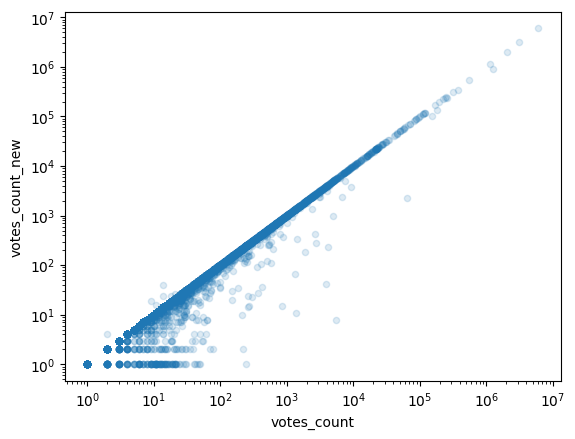

In [38]:
# make a scatterplot comparing votes_count_new and votes_count
deployments_df.plot.scatter(x='votes_count', y='votes_count_new', loglog=True, alpha=0.15)

<Axes: xlabel='votes_count', ylabel='votes_count_new'>

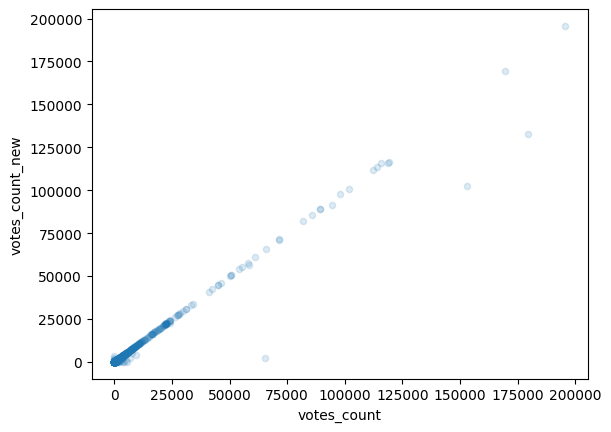

In [39]:
# again wo loglog but cut off after 200_000
deployments_df[deployments_df['votes_count'] < 200_000].plot.scatter(x='votes_count', y='votes_count_new', alpha=0.15)

In [40]:
# the old values are almost always higher than the actual ones, we may be missing data OR
# counting 'votes' in a more conservative way than the platforms do
deployments_df['votes_count'].corr(deployments_df['votes_count_new'])

0.9986771451604365

In [41]:
# how many votes_count are null?
deployments_df['votes_count_new'].isnull().sum()
# fill na with 0
deployments_df['votes_count_new'] = deployments_df['votes_count_new'].fillna(0)
# make type int
deployments_df['votes_count_new'] = deployments_df['votes_count_new'].astype(int)
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count,proposals_count_new,votes_count_new
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",6022932,58,58.0,5986069
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",3135558,2,2.0,3116713
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2034342,368,367.0,2020544
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",1144462,93,93.0,1142459
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",1272067,162,122.0,899961


In [42]:
# drop votes_count, rename votes_count_new to votes_count
deployments_df = deployments_df.drop(columns=['votes_count']).rename(columns={'votes_count_new': 'votes_count'})
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,proposals_count,proposals_count_new,votes_count
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",58,58.0,5986069
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",2,2.0,3116713
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,368,367.0,2020544
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",93,93.0,1142459
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",162,122.0,899961


proposals count

<Axes: xlabel='proposals_count', ylabel='proposals_count_new'>

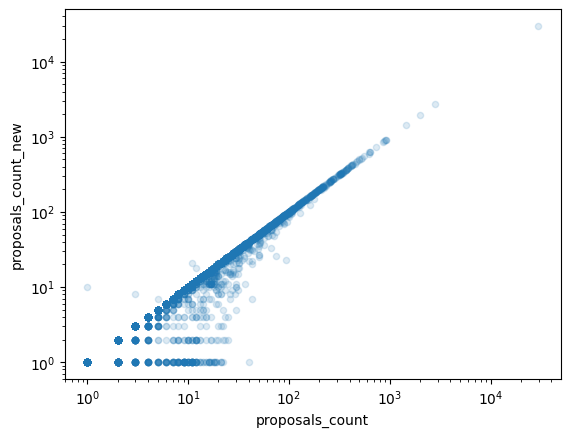

In [43]:
# make a scatterplot comparing proposals_count_new and proposals_count
deployments_df.plot.scatter(x='proposals_count', y='proposals_count_new', loglog=True, alpha=0.15)

<Axes: xlabel='proposals_count', ylabel='proposals_count_new'>

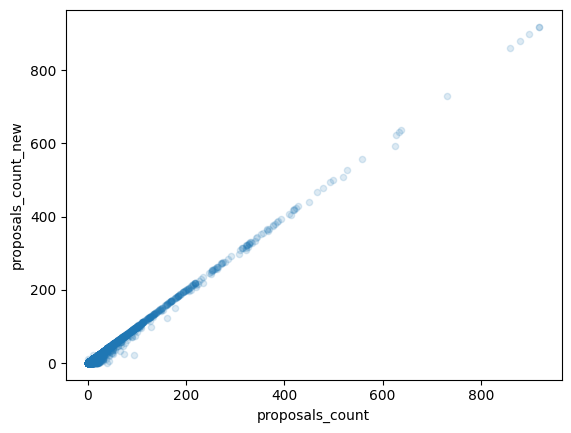

In [44]:
# again wo loglog but cut off after 1000
deployments_df[deployments_df['proposals_count'] < 1000].plot.scatter(x='proposals_count', y='proposals_count_new', alpha=0.15)

In [45]:
deployments_df['proposals_count'].corr(deployments_df['proposals_count_new'])

0.999963004459845

In [46]:
# how many nas
deployments_df['proposals_count_new'].isnull().sum()

10364

In [47]:
# fill na with 0
deployments_df['proposals_count_new'] = deployments_df['proposals_count_new'].fillna(0)
# make type int
deployments_df['proposals_count_new'] = deployments_df['proposals_count_new'].astype(int)
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,proposals_count,proposals_count_new,votes_count
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",58,58,5986069
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",2,2,3116713
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,368,367,2020544
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",93,93,1142459
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",162,122,899961


In [48]:
# remove proposals_count, rename proposals_count_new to proposals_count
deployments_df = deployments_df.drop(columns=['proposals_count']).rename(columns={'proposals_count_new': 'proposals_count'})
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,proposals_count,votes_count
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",58,5986069
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",2,3116713
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,367,2020544
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",93,1142459
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",122,899961


In [49]:
# read in the old deployments schema
import pyarrow.parquet as pq
old_deployments = pq.read_table('../parquets_version3/deployments.parquet')
old_deployments.schema

id: string
platform: string
platform_deployment_id: string
name: string
website: string
additional: string
votes_count: int64
proposals_count: int64

In [50]:
deployments_df = deployments_df[[
    'id',
    'platform',
    'platform_deployment_id',
    'name',
    'website',
    'additional',
    'votes_count',
    'proposals_count'
]]
deployments_df.head()

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,1fe442f5-891f-5a6f-b3a1-1b846a7a8b70,snapshot,stgdao.eth,Stargate DAO,https://snapshot.org/#/stgdao.eth,"stargatefinance, https://stargate.finance/",5986069,58
1,eeed4e65-5607-59e2-a003-fddc8db9ff09,snapshot,linea-build.eth,Linea,https://snapshot.org/#/linea-build.eth,"LineaBuild, https://linea.build/",3116713,2
2,b6c95a58-d36d-5482-9fa0-fffbbed6e20a,snapshot,aave.eth,Aave,https://snapshot.org/#/aave.eth,AaveAave,2020544,367
3,25098163-1cfd-5ad9-9bdc-f4e00b1d611e,snapshot,opcollective.eth,Optimism Collective,https://snapshot.org/#/opcollective.eth,"optimismPBC, https://optimism.io",1142459,93
4,725ff450-578f-5bb8-9caf-75599c2fd5ab,snapshot,magicappstore.eth,Magic Square,https://snapshot.org/#/magicappstore.eth,"MagicSquareio, https://magic.store/",899961,122


In [51]:
# make arrow
import pyarrow as pa
deployments_table = pa.Table.from_pandas(deployments_df)
deployments_table.schema

id: string
platform: string
platform_deployment_id: string
name: string
website: string
additional: string
votes_count: int64
proposals_count: int64
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1215

In [52]:
# save
pq.write_table(deployments_table, '../parquets_version4/deployments.parquet')